# Figure 8 Trajectory with Franka

In [1]:
import pybullet as pb
import pybullet_data

from franka_env import FrankaEnv
import numpy as np

import time
import math
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [2]:
env = FrankaEnv()

In [3]:
def quat_to_euler(q):
    pi = math.pi
    q0 = q[3]
    q1 = q[0]
    q2 = q[1]
    q3 = q[2]
    test = np.dot(q0,q2) - np.dot(q1,q3)
    if (test > 0.4999): 
        phi = math.atan2(q1*q2 - q0*q3, q1*q3 + q0*q2)
        theta = pi/2
        psi= 0
    elif (test < -0.4999):
        phi = math.atan2(- q1*q2 + q0*q3, - q1*q3 - q0*q2)
        theta = -pi/2
        psi = 0
    else:
        sqx = q1*q1
        sqy = q2*q2
        sqz = q3*q3
        
        psi = math.atan2(2*q2*q1+2*q0*q3 , 1 - 2*sqy - 2*sqz) # Yaw
        theta = math.asin(2*test) # Pitch
        phi = math.atan2(2*q2*q3+2*q0*q1 , 1 - 2*sqx - 2*sqy) # Roll
    return phi, theta, psi

def Run_Frank(Steps, state_desired, LQR_gains):
    state = env.reset()
    state_traj = np.empty((Steps+1,14))
    state_traj[:] = np.NaN
    state_traj[0,:] = state[:14]
    control = 0
    for t in range(Steps):
#         [phi, theta, psi] = pb.getEulerFromQuaternion([1,0,0,0])
        [phi, theta, psi] = quat_to_euler(state[3:7])
        state = np.append(np.append(state[0:3], [phi, theta, psi]), state[7:])
        state = np.append(state, 1)
        state_traj[t+1, :] = state[:14]
        control = - np.dot(LQR_gains, (state - state_desired[t,:]))
        state = env.step(control)
#         time.sleep(1.0/60.)
        time.sleep(1.0/300.)
#     print("Actual: ", state[0:3], " ", state[7:13])
#     plt.plot(state_traj[:,1], state_traj[:,2], state_desired[:,1], state_desired[:,2])
#     plt.plot(state_traj[:,1], state_traj[:,2])
#     plt.axis('equal')
#     EF_error = np.linalg.norm(state[0:3] - Desired_Target_end_effector)
#     JA_error = np.linalg.norm(state[7:13] - Links_Des[0:6])
    return state_traj
# plt.plot(state_traj)

In [4]:
# angles of end effector are in quaternions
np.set_printoptions(precision=3)
LQR_gains_unc = loadmat('../LQR_gains_unc.mat', squeeze_me=True)['K_gain']
LQR_gains_sAB = loadmat('../LQR_gains_stableA_and_B.mat', squeeze_me=True)['K_gain']
LQR_gains_sA = loadmat('../LQR_gains_stableA.mat', squeeze_me=True)['K_gain']

## Design Desired Figure-8 Trajectory

### End-Effector Positions for Figure-8

## End Effector & Joint Angles

In [11]:
np.set_printoptions(precision=3)
LQR_gains_unc = loadmat('LQR_gains_unc.mat', squeeze_me=True)['K_gain']
LQR_gains_sAB = loadmat('LQR_gains_stableA_and_B.mat', squeeze_me=True)['K_gain']
# LQR_gains_sA = loadmat('../LQR_gains_stableA.mat', squeeze_me=True)['K_gain']

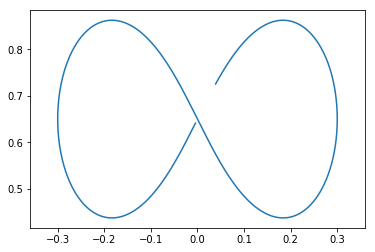

In [17]:
T = 30
t = 0.2*np.linspace(0, T, T*50+1)
t = t + 1.6
a = 0.3
z = 0.65 + 2 * a * np.sin(t) * np.cos(t) / (1+np.sin(t)**2)
z = np.expand_dims(z, axis = 1)
y =  a * np.cos(t) / (1+np.sin(t)**2)
y = np.expand_dims(y, axis=1)
x = 0.3*np.ones((len(y),1))
plt.plot(y,z)
plt.axis('equal')
JointAngles_Fig8 = np.empty((len(t),7))
JointAngles_Fig8[:] = np.NaN
for i in range(len(t)):
    JointAngles_Fig8[i,:] = pb.calculateInverseKinematics(env.robot, env.ee_id, [x[i], y[i], z[i]])[:7]
#     JointAngles_Fig8[i,:] = pb.calculateInverseKinematics(env.robot, env.ee_id, [x[0], y[0], z[0]], [1,0,0,0])[:7]

phi = np.ones((len(y), 1))
theta = np.ones((len(y), 1))
psi = np.ones((len(y), 1))
state_des = np.concatenate( (x, y, z, phi, theta, psi, JointAngles_Fig8, np.zeros((len(y), 7)), np.ones((len(y), 1))), axis = 1)

Steps = len(t)
state = env.reset()
state_traj = np.empty((Steps+1,14))
state_traj[:] = np.NaN
state_traj[0,:] = state[0:14]

NameError: name 'source' is not defined

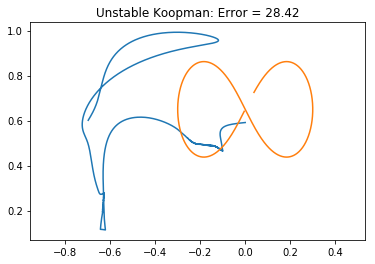

In [18]:
state_traj_unc = Run_Frank(Steps, state_des, LQR_gains_unc)
fig = plt.plot(state_traj_unc[:,1], state_traj_unc[:,2], state_des[:,1], state_des[:,2])
plt.axis('equal')
plt.title('Unstable Koopman: Error = {0:.2f}'.format(np.linalg.norm(state_traj_unc[1:,:3] - state_des[:,:3])), fontdict=None, loc='center', pad=None)
plt.savefig('Unstable Koopman - Fig8 - 1000 Measurements.pdf', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)[source]
# print("Norm from end effector trajectory is ",  np.linalg.norm(state_traj_unc[1:,:3] - state_des[:,:3]))

NameError: name 'source' is not defined

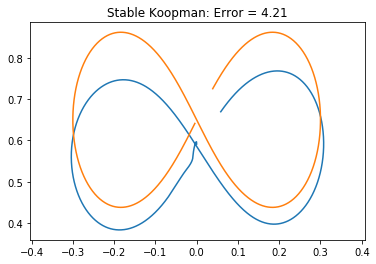

In [19]:
state_traj_unc = Run_Frank(Steps, state_des, LQR_gains_sAB)
fig = plt.plot(state_traj_unc[:,1], state_traj_unc[:,2], state_des[:,1], state_des[:,2])
plt.axis('equal')
plt.title('Stable Koopman: Error = {0:.2f}'.format(np.linalg.norm(state_traj_unc[1:,:3] - state_des[:,:3])), fontdict=None, loc='center', pad=None)
plt.savefig('Stable Koopman - Fig8 - 1000 Measurements.pdf', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)[source]
# print("Norm from end effector trajectory is ",  np.linalg.norm(state_traj_unc[1:,:3] - state_des[:,:3]))

In [22]:
# state_traj_unc = Run_Frank(Steps, state_des, LQR_gains_sA)
np.save('desired_trajectory.npy', state_des)